In [4]:
config = {
    # AdobeVFR params
    "num_fonts": 100,
    "data_root": "adobevfr",
    "all_font_path": "adobevfr/fontlist.txt",
    "subset_font_path": "adobevfr/fontsubset.txt",
    "split_paths": {
        "train": "training/train",
        "val":   "validation/val",
        "test":  "evaluation/test",
    },

    # Training params
    "num_epochs": 50,
    "batch_size": 128,
    "lr": 0.01,
    "momentum": 0.9,
    "weight_decay": 5e-4
}

### Create font subset

In [ ]:
def save_font_subset():
    with open(config["all_font_path"], 'r') as f:
        fonts = [line for line in f if '-' not in line][:config["num_fonts"]]

    # Write subset
    with open(config["subset_font_path"], 'w') as out:
        out.writelines(fonts)
        print(f"Saved {config['num_fonts']} to {config['subset_font_path']}")

save_font_subset()


### Create Adobe VFR Dataset

In [3]:
from pathlib import Path

import cv2
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset


class AdobeVFRDataset(Dataset):
    def __init__(self, bcf_dir, split, all_fonts, subset_fonts, transform=None):
        bcf_dir = Path(bcf_dir)
        self.bcf_file = bcf_dir / f"{split}.bcf"

        labels = self._read_u32(bcf_dir / f"{split}.label")
        all_fonts = self._read_lines(all_fonts)
        sub_fonts = self._read_lines(subset_fonts)

        orig2compact = {all_fonts.index(n): i for i, n in enumerate(sub_fonts)}
        keep = np.isin(labels, list(orig2compact))
        self.idx = np.nonzero(keep)[0]
        self.labels = np.array([orig2compact[x] for x in labels[self.idx]],
                               dtype=np.int64)

        self._load_offsets()
        self.transform = transform

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, i):
        real_i = int(self.idx[i])
        raw = self._entry_bytes(real_i)
        img = cv2.imdecode(np.frombuffer(raw, np.uint8), cv2.IMREAD_UNCHANGED)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(image=np.array(img))["image"]

        return img, torch.tensor(self.labels[i], dtype=torch.long)

    # ---------------- internal ----------------
    def _load_offsets(self):
        with self.bcf_file.open("rb") as f:
            n = int(np.frombuffer(f.read(8), np.uint64)[0])
            sizes = np.frombuffer(f.read(8 * n), np.uint64)

        # Keep as uint64 throughout
        self._offs = np.append(np.uint64(0), np.add.accumulate(sizes).astype(np.uint64))

    def _entry_bytes(self, i):
        hdr = len(self._offs) * 8                        
        a = int(self._offs[i])                            
        b = int(self._offs[i + 1])
        with self.bcf_file.open("rb") as f:
            f.seek(hdr + a)
            return f.read(b - a)
        
    def _read_u32(self, path):
        """uint32 binary file → int32 NumPy array."""
        return np.fromfile(path, np.uint32).astype(np.int32)

    def _read_lines(self, path):
        """Text file → stripped, non-empty line list."""
        return [ln.strip() for ln in Path(path).read_text().splitlines() if ln.strip()]

/home/austin/.venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2


class ResizeHeight(ImageOnlyTransform):
    def __init__(self, h=105, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.h = h

    def apply(self, img, **_):
        ih, iw = img.shape[:2]
        nw = round(self.h * iw / ih)
        return cv2.resize(img, (nw, self.h), cv2.INTER_LANCZOS4)


class PickRandomPatch(ImageOnlyTransform):
    def __init__(self, step=105, constrained=False,
                 drop_last=False, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.step, self.constrained, self.drop_last = step, constrained, drop_last

    def _pad(self, img):
        ih, iw = img.shape
        if iw < self.step:
            pad = np.full((ih, self.step - iw), 255, np.uint8)
            return np.concatenate((img, pad), 1)
        return img

    def apply(self, img, **_):
        img = self._pad(img)
        _, w = img.shape
        if not self.constrained:
            sx = np.random.randint(0, w - self.step + 1)
            return img[:, sx:sx + self.step]

        # constrained: pick among non-overlapping tiles
        tiles = (w + self.step - 1) // self.step
        if self.drop_last and w % self.step:
            tiles -= 1
        sel = np.random.randint(tiles)
        sx = sel * self.step
        tile = img[:, sx:sx + self.step]
        return self._pad(tile)


class VariableAspectRatio(ImageOnlyTransform):
    def __init__(self, lo=0.83, hi=1.17, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.lo, self.hi = lo, hi

    def apply(self, img, **_):
        h, w = img.shape
        r = np.random.uniform(self.lo, self.hi)
        nw = round(w * r)
        return cv2.resize(img, (nw, h), cv2.INTER_LANCZOS4)


class Squeezing(ImageOnlyTransform):
    def __init__(self, ratio=2.5, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.ratio = ratio

    def apply(self, img, **_):
        h, _ = img.shape
        nw = round(h * self.ratio)
        return cv2.resize(img, (nw, h), cv2.INTER_LANCZOS4)

# ── pipelines ─────────────────────────────────────────────────────────────

BASE_AUG = A.OneOf([
    A.GaussNoise(var_limit=(3.0, 4.0)),
    A.GaussianBlur(blur_limit=(1, 3))
], p=0.5)

AFFINE_NOISE = A.OneOf([
    A.Affine(rotate=[-3, 3], cval=255),
    A.MultiplicativeNoise(multiplier=(0.3, 0.8))
], p=0.5)

FEATURE_ENH = A.Sequential([
    VariableAspectRatio(always_apply=True),
    Squeezing(always_apply=True)
])

PATCH = A.Sequential([
    PickRandomPatch(constrained=False, always_apply=True),
    A.ToFloat(255, always_apply=True),
    ToTensorV2()
])

PIPELINES = {
    "deepfont_train": A.Compose([
        ResizeHeight(always_apply=True),
        BASE_AUG, AFFINE_NOISE,
        FEATURE_ENH,
        PATCH
    ]),
    "random_square_patch": A.Compose([
        ResizeHeight(always_apply=True),
        FEATURE_ENH,
        PATCH
    ]),
    "test": lambda sq: A.Sequential([
        ResizeHeight(always_apply=True),
        Squeezing(ratio=sq, always_apply=True)
    ])
}

In [5]:
from torch.utils.data import DataLoader

def make_dataset(split_path, transform):
    return AdobeVFRDataset(
        bcf_dir=config["data_root"],
        split=split_path,
        all_fonts=config["all_font_path"],
        subset_fonts=config["subset_font_path"],
        transform=transform,
    )


train_ds = make_dataset(config["split_paths"]["train"], transform=PIPELINES["deepfont_train"])
test_ds = make_dataset(config["split_paths"]["val"], transform=PIPELINES["deepfont_train"])

trainloader = DataLoader(
    train_ds,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=0,      
)

testloader = DataLoader(
    test_ds,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=0,
)

print(f"dataset sizes — train {len(train_ds)}, val {len(test_ds)}")

dataset sizes — train 100000, val 10000


torch.Size([128, 1, 105, 105])


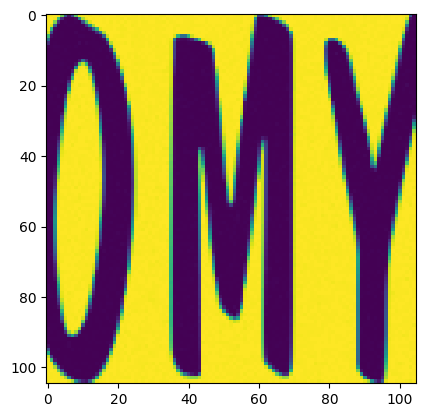

In [6]:
import matplotlib.pyplot as plt
imgs, labels = next(iter(trainloader))
print(imgs.shape)
plt.imshow(imgs[0,0]);

In [7]:
# Encoder and DeepFont PyTorch model instantiations

import torch.nn as nn
import torch.nn.functional as F


class DeepFontAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=64, kernel_size=12, stride=2, padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            # See https://stackoverflow.com/a/58207809/261698
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.ConvTranspose2d(
                in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=1,
                kernel_size=12,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class DeepFont(nn.Module):
    def __init__(self, autoencoder: DeepFontAutoencoder, num_classes: int):
        super().__init__()

        # Cross-domain subnetwork layers (Cu)
        # This is coming from the encoder.
        self.ae_encoder = autoencoder.encoder
        # Make sure we don't train the autoencoder again.
        for param in self.ae_encoder.parameters():
            param.requires_grad = False

        # Domain-specific layers (Cs)
        self.conv5 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, padding=1
        )
        self.conv6 = nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, padding=1
        )
        self.conv7 = nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, padding=1
        )

        self.flatten = nn.Flatten()

        hidden_units = 4096
        self.fc1 = nn.Linear(256 * 12 * 12, hidden_units)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_units, num_classes)

    def forward(self, x):
        # Cu Layers
        with torch.no_grad():
            out = self.ae_encoder(x)

        # Cs Layers
        out = F.relu(self.conv5(out))
        out = F.relu(self.conv6(out))
        out = F.relu(self.conv7(out))

        out = self.flatten(out)

        out = F.relu(self.fc1(out))
        out = self.drop1(out)
        out = F.relu(self.fc2(out))
        out = self.drop2(out)
        out = self.fc3(out)

        return out

In [8]:
# Training/testing helper functions
from tqdm import tqdm
import torch.optim as optim

def train_autoencoder(
        model, trainloader, testloader, epochs=20, lr=0.1, momentum=0.9,
        weight_decay=5e-4, device="cpu", save_path=None,
):
    criterion = nn.MSELoss()
    train(
        model, trainloader, testloader, epochs, lr, momentum,
        criterion, weight_decay, device, save_path
    )

def train_deepfont(
        model, trainloader, testloader, epochs=20, lr=0.1, momentum=0.9,
        weight_decay=5e-4, device="cpu", save_path=None,
):
    criterion = nn.CrossEntropyLoss()
    train(
        model, trainloader, testloader, epochs, lr, momentum,
        criterion,weight_decay, device, save_path
    )

def train(
    model, train_loader, test_loader, epochs, lr, momentum,
    criterion, weight_decay, device="cpu", save_path=None
):
    """
    Train the model using SGD and CosineAnnealingLR.
    """

    print(f"\nTraining on device = {device}!")
    device = torch.device(device)
    model.to(device)

    # Determine if this is the autoencoder or deepfont
    is_autoencoder = isinstance(criterion, nn.MSELoss)

    optimizer = optim.SGD(
        model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs)

    best_acc = 0.0
    
    for epoch in range(epochs):
        train_epoch(epoch, model, train_loader, criterion, optimizer, device, is_autoencoder)
        test_acc = test_epoch(model, test_loader, criterion, device, is_autoencoder)

        # Save the model if the test accuracy improves
        if save_path and test_acc > best_acc:
            print(f"Saving model with accuracy: {test_acc:.3f}")
            best_acc = test_acc
            state = {
                "model_state_dict": model.state_dict(),
                "acc": test_acc,
                "epoch": epoch,
            }
            torch.save(state, save_path)

        scheduler.step()

    model.to("cpu")


def train_epoch(epoch, model, train_loader, criterion, optimizer, device, is_autoencoder=False):
    """
    Perform one training epoch.
    """
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    print(f"\nEpoch: {epoch + 1}")
    train_bar = tqdm(
        enumerate(train_loader), total=len(train_loader),
        desc="Training", leave=False
    )

    for batch_idx, (inputs, targets) in train_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        
        if is_autoencoder:
            # Autoencoder case: reconstruct inputs
            x_hat = model(inputs)
            loss = criterion(inputs, x_hat)  # MSE between original and reconstructed
            train_loss += loss.item()
            correct = total = 0  # No classification accuracy for autoencoder
        else:
            # Classification case (DeepFont)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        loss.backward()
        optimizer.step()

        # Update progress bar
        if is_autoencoder:
            train_bar.set_postfix({
                "Loss": f"{train_loss / (batch_idx + 1):.3f}"
            })
        else:
            train_bar.set_postfix({
                "Loss": f"{train_loss / (batch_idx + 1):.3f}",
                "Acc": f"{100. * correct / total:.3f}% ({correct}/{total})"
            })


def test_epoch(model, test_loader, criterion, device, is_autoencoder=False):
    """
    Evaluate the model on the test dataset.
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_bar = tqdm(
        enumerate(test_loader), total=len(test_loader),
        desc="Testing", leave=False
    )

    with torch.no_grad():
        for batch_idx, (inputs, targets) in test_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            if is_autoencoder:
                # Autoencoder case: reconstruct inputs
                x_hat = model(inputs)
                loss = criterion(inputs, x_hat)
                test_loss += loss.item()
                correct = total = 0  # No classification accuracy for autoencoder
            else:
                # Classification case (DeepFont)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            # Update progress bar
            if is_autoencoder:
                test_bar.set_postfix({
                    "Loss": f"{test_loss / (batch_idx + 1):.3f}"
                })
            else:
                test_bar.set_postfix({
                    "Loss": f"{test_loss / (batch_idx + 1):.3f}",
                    "Acc": f"{100. * correct / total:.3f}% ({correct}/{total})"
                })

    # Return accuracy for classification, or a dummy value for autoencoders
    return 100. * correct / total if not is_autoencoder else 0.0

In [ ]:
# Main functions
auto = DeepFontAutoencoder()
deepfont = DeepFont(auto, num_classes=config["num_fonts"])

device = "cuda" if torch.cuda.is_available() else "cpu"

# First train the autoencoder
train_autoencoder(
    auto, trainloader, testloader, epochs=config["num_epochs"], lr=config["lr"],
    weight_decay=config["weight_decay"], device=device, save_path=None,
)

# Then freeze the autoencoder and train the later deepfont layers
train_deepfont(
    deepfont, trainloader, testloader, epochs=config["num_epochs"], lr=config["lr"],
    weight_decay=config["weight_decay"], device=device, save_path=None,
)


Training on device = cuda!

Epoch: 1


Training:   0%|          | 2/782 [00:02<15:26,  1.19s/it, Loss=0.246]